# Analiza opinii z twittera 
## Opinie o Joe Biden 2019-2021 (przed wyborami, w trakcie i po)

In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import text2emotion as te

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


biblioteki potrzebne przy analizie

KeyboardInterrupt: 

In [ ]:
import snscrape.modules.twitter as sntwitter

maxTweets = 100

tweets_list = []


year = 2019
month = 1
day = 1


for x in range(2):
    for y in range(12):
        for j in range(28):  
            for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'#biden until:{year}-{month}-{day}').get_items()): #f'#biden until:{year}-{month}-{day}'
                if i>maxTweets:
                    break
                tweets_list.append([tweet.date, tweet.content])
            day += 1
        month += 1
        day = 1
    year += 1
    month = 1


# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list, columns=['Date', 'Text'])

tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date

#save the tweets to a csv file 
tweets_df.to_csv('text-query-tweets.csv', sep=',', index=False)

### baza danych
pobieramy bazę danych angielskich tweetów z hasztagiem #biden w przedziale od 1 stycznia 2019 roku do 28 grudnia 2020 roku\
\
tweety zapisujemy w pliku csv

In [5]:
tweets_df = pd.read_csv('text-query-tweets.csv', parse_dates=['Date'])

z pliku tworzymy DataFrame

In [5]:
print(tweets_df.shape[0])

67872


Nasza baza danych ma dokładnie 67872 tweety

# Preprocessing

In [6]:

tweets_df['Text'] = tweets_df['Text'].apply(lambda x: x.lower())

lemmatizer = WordNetLemmatizer()

tweets_df_lemmatized = tweets_df.copy()

stop_words = stopwords.words('english')

def lemmatize_sentence(sentence):
    words_to_remove = re.findall(r'@\w+|https://\S+', sentence)
    word_list = sentence.split()
    filtered_words = [word for word in word_list if word not in words_to_remove]
    new_text = ' '.join(filtered_words)
    sentence_tokens = word_tokenize(new_text.lower())
    stop_words = stopwords.words('english')
    stop_words.extend(['#', ',','\'','`'])
    filtered_tokens = [token for token in sentence_tokens if token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

tweets_df_lemmatized['Text'] = tweets_df_lemmatized['Text'].apply(lambda x: lemmatize_sentence(x))

            Date                                               Text
0     2018-12-31  [elizabethwarren, first, exploratory-committee...
1     2018-12-31  [insider, fyi, cornell-, husband, hired, right...
2     2018-12-31  [yeah, called, democrat, ., clinton, biden, bo...
3     2018-12-31  [elizabethwarren, 5th, candidate, enter, 2020,...
4     2018-12-31  [long, dem, nom, battle, kept, positive, 's, b...
...          ...                                                ...
67867 2020-12-27  [biden, say, trump, 's, 'abdication, responsib...
67868 2020-12-27  [believe, joe, biden, camp, nashville, destroy...
67869 2020-12-27  [lolz, ’, corrupt, party, put, corporate, dono...
67870 2020-12-27  [biden, insan, hakları, konusunda, trump, ’, t...
67871 2020-12-27  [., @, joebiden, swampprevention, ., ’, look, ...

[67872 rows x 2 columns]


słowa w tweetach sprowadzamy do małych liter, by w dalszej części nie powielać tych samych słów które algorytm będzie nam odczytywał jako różne

z bazy usuwamy słowa rozpoczynające się od '@' - nazwy użytkowników i linki 'https', by nie był brane pod uwagę\
tokenizujemy slowa\
filtrujemy poprzez usunięcie tzw 'stopwords'\
następnie lematyzujemy tweety w celu sprowadzenia słowa do jego formy podstawowej

In [26]:
tweets_df_compound = tweets_df_lemmatized.copy()

sid = SentimentIntensityAnalyzer()

tweets_df_compound['Compound'] = tweets_df_compound['Text'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])

tworzymy baze danych dla której każdy tweet będzie miał swój poziom pozytywności/negatywności

In [33]:
max_compound = tweets_df_compound['Compound'].max()
min_compound = tweets_df_compound['Compound'].min()
print("max: ", max_compound, "min: ",min_compound)

max:  0.9888 min:  -0.9919


In [8]:

tweets_df_vadered = tweets_df_lemmatized.copy()
sid = SentimentIntensityAnalyzer()

tweets_df_vadered['Opinion'] = tweets_df_vadered['Text'].apply(lambda x: sid.polarity_scores(' '.join(x)))
tweets_df_vadered['Opinion'] = tweets_df_vadered['Opinion'].apply(lambda x: 'positive' if x['compound'] >= 0.2 else 'negative' if x['compound'] <= -0.2 else 'neutral')

positive


tworzymy nowy dataFrame, dodając kolumne definiującą opinie o tweecie

In [23]:
tweets_df_emotioned = tweets_df_lemmatized.copy()

tweets_df_emotioned['Emotion'] = tweets_df_emotioned['Text'].apply(lambda x: te.get_emotion(' '.join(x)))

print(tweets_df_emotioned['Emotion'][0])

{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.5}


In [ ]:
tweets_df_emotioned = pd.read_csv('text-query-tweets-emotioned.csv', parse_dates=['Date'])

tworzymy bazę danych w której będziemy przechowywać dane o emocjach towarzyszących tweetom

In [61]:
tweets_df_emotioned['emotion_max'] = tweets_df_emotioned['Emotion'].apply(lambda x: max(x, key=x.get) if x[max(x, key=x.get)] != 0 else 'noemotions')

In [60]:
tweets_df_emotioned.to_csv('text-query-tweets-emotioned.csv', sep=',', index=False)

tworzymy nowy dataFrame, dodając kolumnę definiującą emocje związane z tym tweetem

# Analiza całościowa

In [ ]:
tweets_list_positive = []
tweets_list_negative = []

tweets_list_happy = []
tweets_list_angry = []
tweets_list_sad = []
tweets_list_fear = []
tweets_list_surprise = []

tworzymy listy do przechowania słów dla poszczegółnych opinii(pozytywne, negatywne) i emocji (szczęście, złość, smutek, strach, zaskoczenie)

In [64]:
for index,row in tweets_df_vadered.iterrows():
    if row['Opinion'] == 'positive':
        tweets_list_positive.extend(row['Text'])
    elif row['Opinion'] == 'negative':
        tweets_list_negative.extend(row['Text'])

for index,row in tweets_df_emotioned.iterrows():
    if row['emotion_max'] == 'Happy':
        tweets_list_happy.extend(row['Text'])
    elif row['emotion_max'] == 'Angry':
        tweets_list_angry.extend(row['Text'])
    elif row['emotion_max'] == 'Sad':
        tweets_list_sad.extend(row['Text'])
    elif row['emotion_max'] == 'Fear':
        tweets_list_fear.extend(row['Text'])
    elif row['emotion_max'] == 'Surprise':
        tweets_list_surprise.extend(row['Text'])

do list dodajemy słowa które są zawarte w tweetach im odpowiadającym

<AxesSubplot:xlabel='frequency', ylabel='word'>

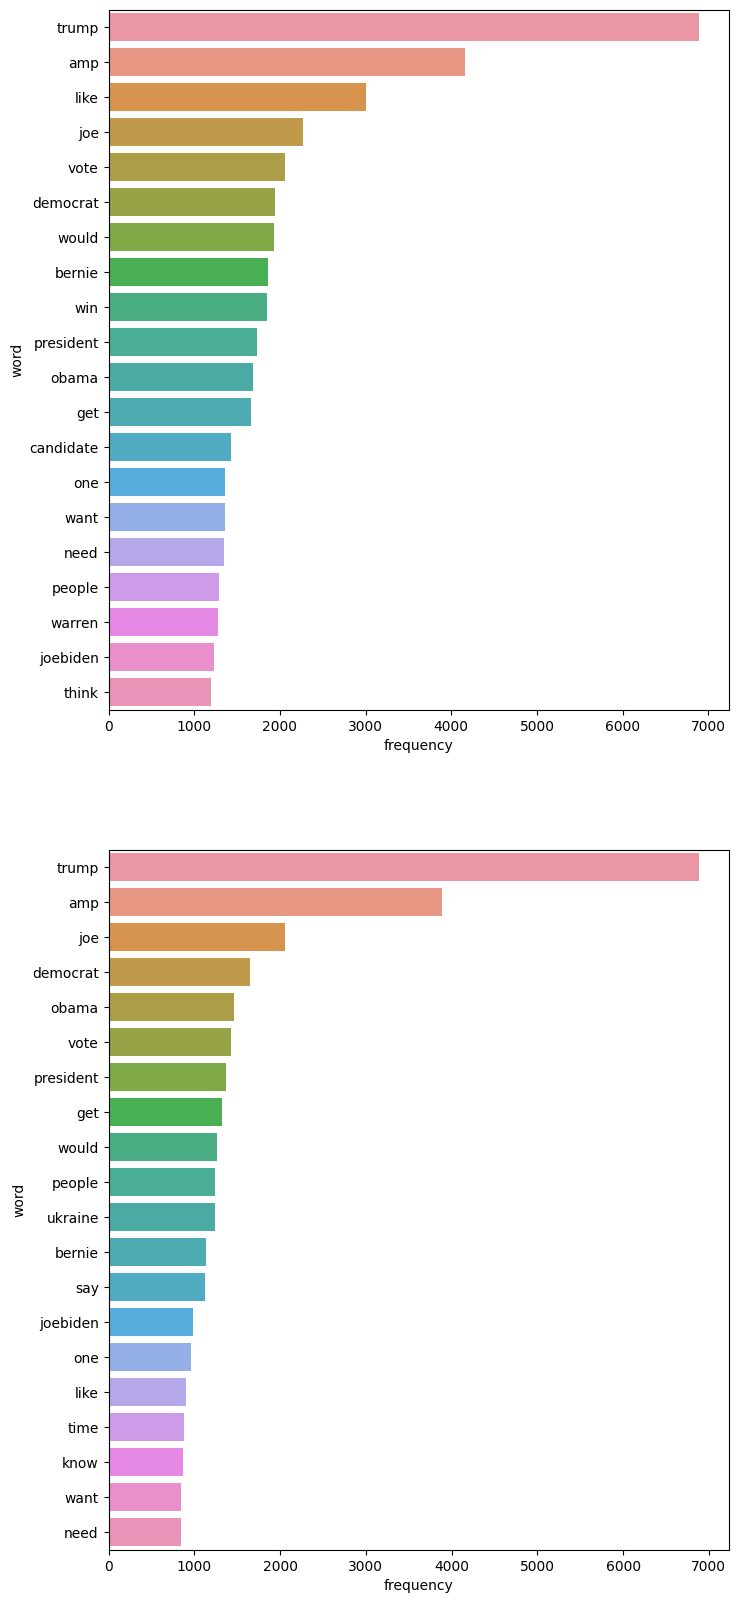

In [65]:
stop_words = stopwords.words('english')
stop_words.extend(['.',',','!',',','biden','`','\'','?',':','\'s','&',';','n\'t','(',')','\``','"',"'",'\'\'','’','...','``','%','@','-','u','“','”'])

new_tokens_positive =[t for t in tweets_list_positive if t not in stop_words]

counted_positive = Counter(new_tokens_positive)

word_freq_positive = pd.DataFrame(counted_positive.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

new_tokens_negative =[t for t in tweets_list_negative if t not in stop_words]

counted_negative = Counter(new_tokens_negative)

word_freq_negative = pd.DataFrame(counted_negative.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
fig, axes = plt.subplots(2,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_positive.head(20))
sns.barplot(ax=axes[1],x='frequency',y='word',data=word_freq_negative.head(20))

Wyniki występowania słów dla opinii pozytywnych i negatywnych\
w obu przypadkach najczęsciej występującym słowem jest 'Trump', ponieważ był to jego przeciwnik w wyborach 2020\
całościowo, większość słów odnosi się do wyborów prezydenckich w Usa i partii politycznej demokratów

In [66]:
new_tokens_happy =[t for t in tweets_list_happy if t not in stop_words]
new_tokens_angry =[t for t in tweets_list_angry if t not in stop_words]
new_tokens_sad =[t for t in tweets_list_sad if t not in stop_words]
new_tokens_fear =[t for t in tweets_list_fear if t not in stop_words]
new_tokens_surprise =[t for t in tweets_list_surprise if t not in stop_words]

counted_happy = Counter(new_tokens_happy)
counted_angry = Counter(new_tokens_angry)
counted_sad = Counter(new_tokens_sad)
counted_fear = Counter(new_tokens_fear)
counted_surprise = Counter(new_tokens_surprise)

word_freq_happy = pd.DataFrame(counted_happy.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_angry = pd.DataFrame(counted_angry.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_sad = pd.DataFrame(counted_sad.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_fear = pd.DataFrame(counted_fear.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
word_freq_surprise = pd.DataFrame(counted_surprise.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)


<AxesSubplot:xlabel='frequency', ylabel='word'>

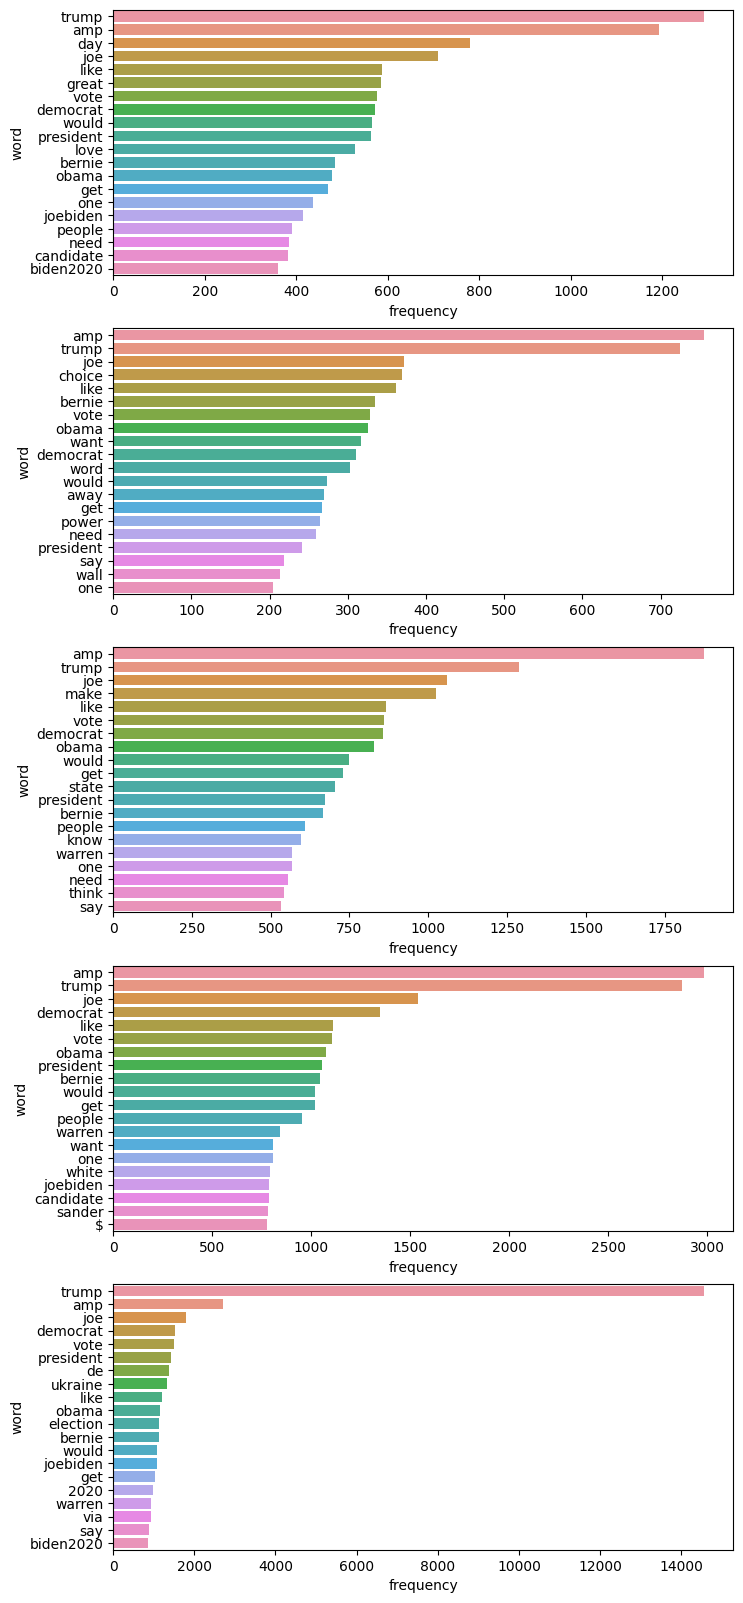

In [68]:
fig, axes = plt.subplots(5,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq_happy.head(20),)
sns.barplot(ax=axes[1],x='frequency',y='word',data=word_freq_angry.head(20))
sns.barplot(ax=axes[2],x='frequency',y='word',data=word_freq_sad.head(20))
sns.barplot(ax=axes[3],x='frequency',y='word',data=word_freq_fear.head(20))
sns.barplot(ax=axes[4],x='frequency',y='word',data=word_freq_surprise.head(20))

zestawienie dla tweetów podzielonych na emocje towarzyszące:
- Happiness (szczęście)
- Angriness (złość)
- Sad (smutek)
- Fear (przerażenie)
- Surprise (zaskoczenie)
wykresy zabardzo od siebie nie odbiegają, z wyjątkiem wykresu dla Surprise. Słowo 'Trump' przejęło tam znaczącą przewagę, możliwe że z powodu kontrowersji związanych z przeciwnikiem Bidena

# Analiza Czasowa

In [101]:
tweets_df_compound['Date'] = pd.to_datetime(tweets_df_compound['Date'])

daily_compound_df = tweets_df_compound.groupby(tweets_df_compound['Date'].dt.date)['Compound'].mean()

Date
2018-12-27    0.206957
2018-12-28    0.242158
2018-12-29    0.166655
2018-12-30    0.025600
2018-12-31    0.371729
Name: Compound, dtype: float64


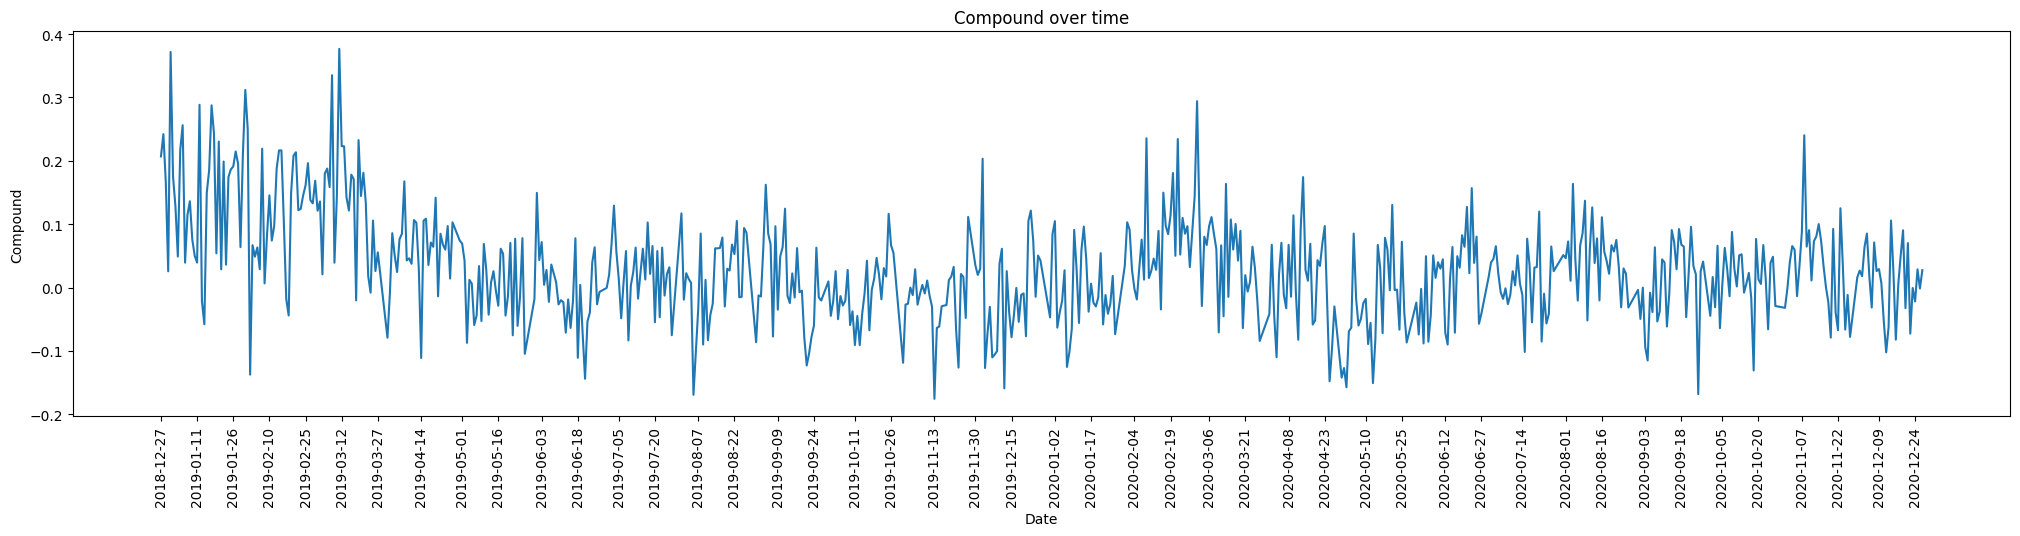

In [102]:
plt.figure(figsize=(25, 5))
plt.plot(daily_compound_df.index, daily_compound_df.values)
plt.xlabel('Date')
plt.ylabel('Compound')
plt.title('Compound over time')
plt.xticks(daily_compound_df.index[::15], rotation=90)


plt.show()

Wykres przedstawia analizę opinii (pozytywna/negatywna) od początku 2019 do końca 2020 roku. Na początku roku 2019 można zauważyć bardziej pozytywne tweety na temat bidena, po tym czasie opinia utrzymuje się stała

In [94]:
tweets_df_emotioned['Happy'] = tweets_df_emotioned['Emotion'].apply(lambda x: x['Happy'])
tweets_df_emotioned['Angry'] = tweets_df_emotioned['Emotion'].apply(lambda x: x['Angry'])
tweets_df_emotioned['Sad'] = tweets_df_emotioned['Emotion'].apply(lambda x: x['Sad'])
tweets_df_emotioned['Fear'] = tweets_df_emotioned['Emotion'].apply(lambda x: x['Fear'])
tweets_df_emotioned['Surprise'] = tweets_df_emotioned['Emotion'].apply(lambda x: x['Surprise'])

tweets_df_emotioned['Date'] = pd.to_datetime(tweets_df_compound['Date'])

daily_happy_df = tweets_df_emotioned.groupby(tweets_df_emotioned['Date'].dt.date)['Happy'].mean()
daily_angry_df = tweets_df_emotioned.groupby(tweets_df_emotioned['Date'].dt.date)['Angry'].mean()
daily_sad_df = tweets_df_emotioned.groupby(tweets_df_emotioned['Date'].dt.date)['Sad'].mean()
daily_fear_df = tweets_df_emotioned.groupby(tweets_df_emotioned['Date'].dt.date)['Fear'].mean()
daily_surprise_df = tweets_df_emotioned.groupby(tweets_df_emotioned['Date'].dt.date)['Surprise'].mean()
print(daily_happy_df.head())

Date
2018-12-27    0.088333
2018-12-28    0.178485
2018-12-29    0.090909
2018-12-30    0.044167
2018-12-31    0.092258
Name: Happy, dtype: float64


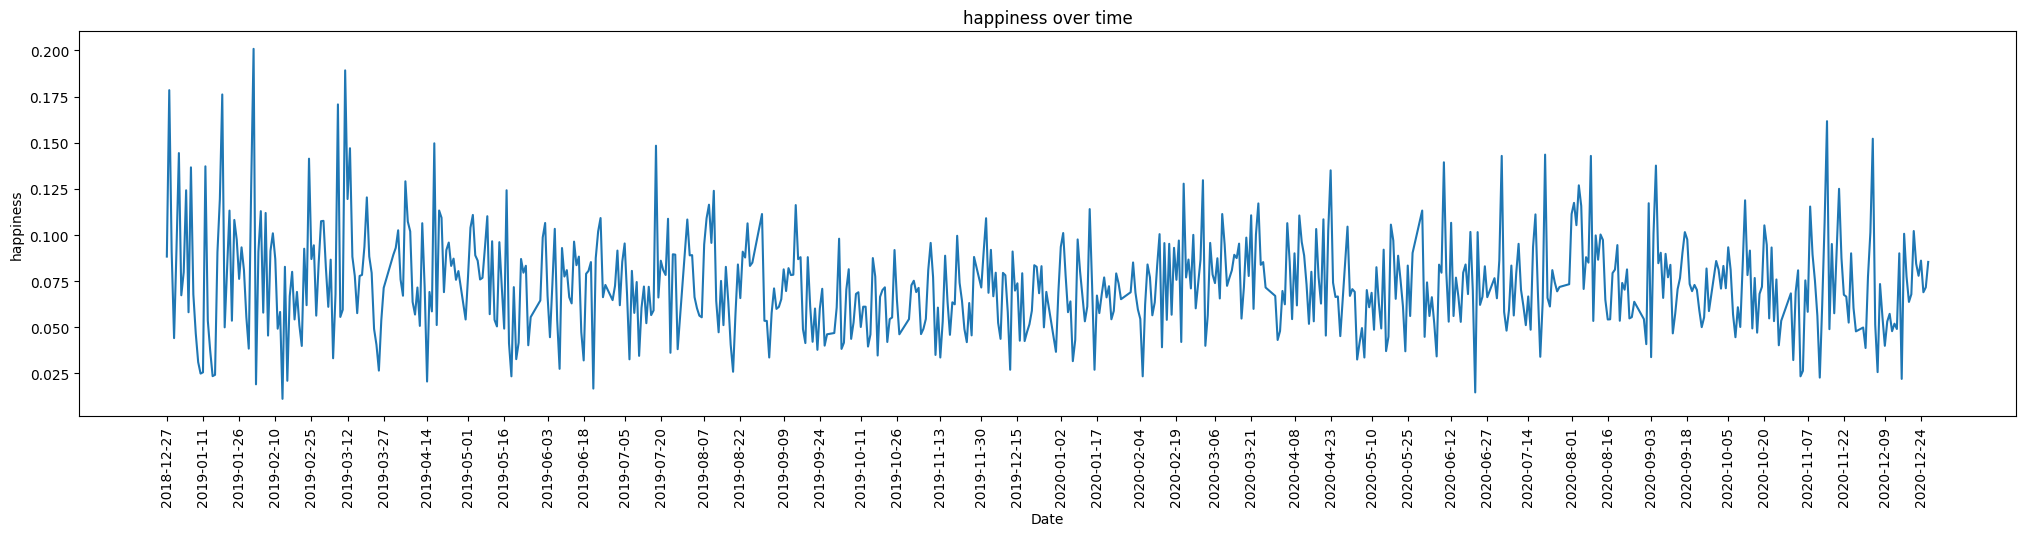

In [95]:
plt.figure(figsize=(25, 5))
plt.plot(daily_happy_df.index, daily_happy_df.values)
plt.xlabel('Date')
plt.ylabel('happiness')
plt.title('happiness over time')
plt.xticks(daily_happy_df.index[::15], rotation=90)
plt.show()

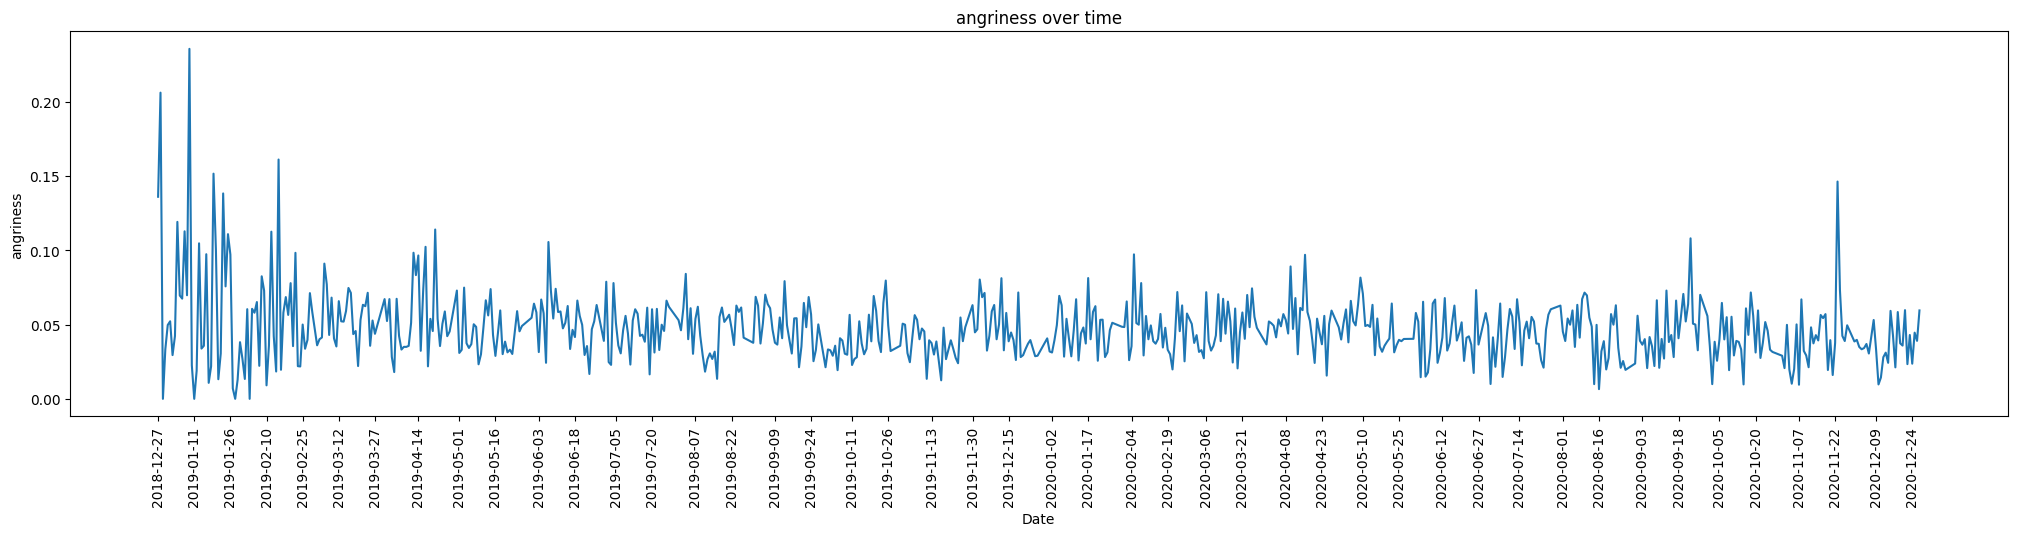

In [96]:
plt.figure(figsize=(25, 5))
plt.plot(daily_angry_df.index, daily_angry_df.values)
plt.xlabel('Date')
plt.ylabel('angriness')
plt.title('angriness over time')
plt.xticks(daily_angry_df.index[::15], rotation=90)
plt.show()

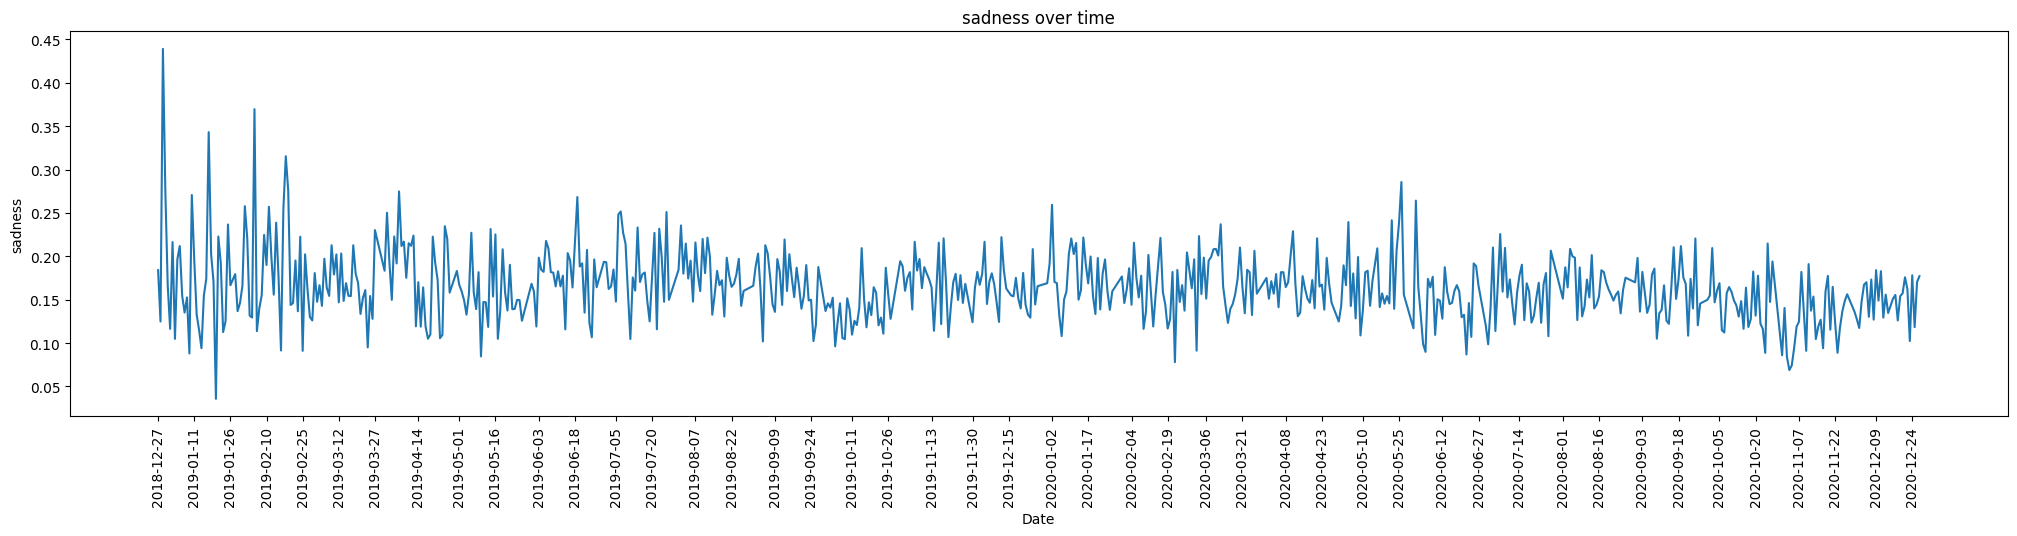

In [97]:
plt.figure(figsize=(25, 5))
plt.plot(daily_sad_df.index, daily_sad_df.values)
plt.xlabel('Date')
plt.ylabel('sadness')
plt.title('sadness over time')
plt.xticks(daily_sad_df.index[::15], rotation=90)
plt.show()

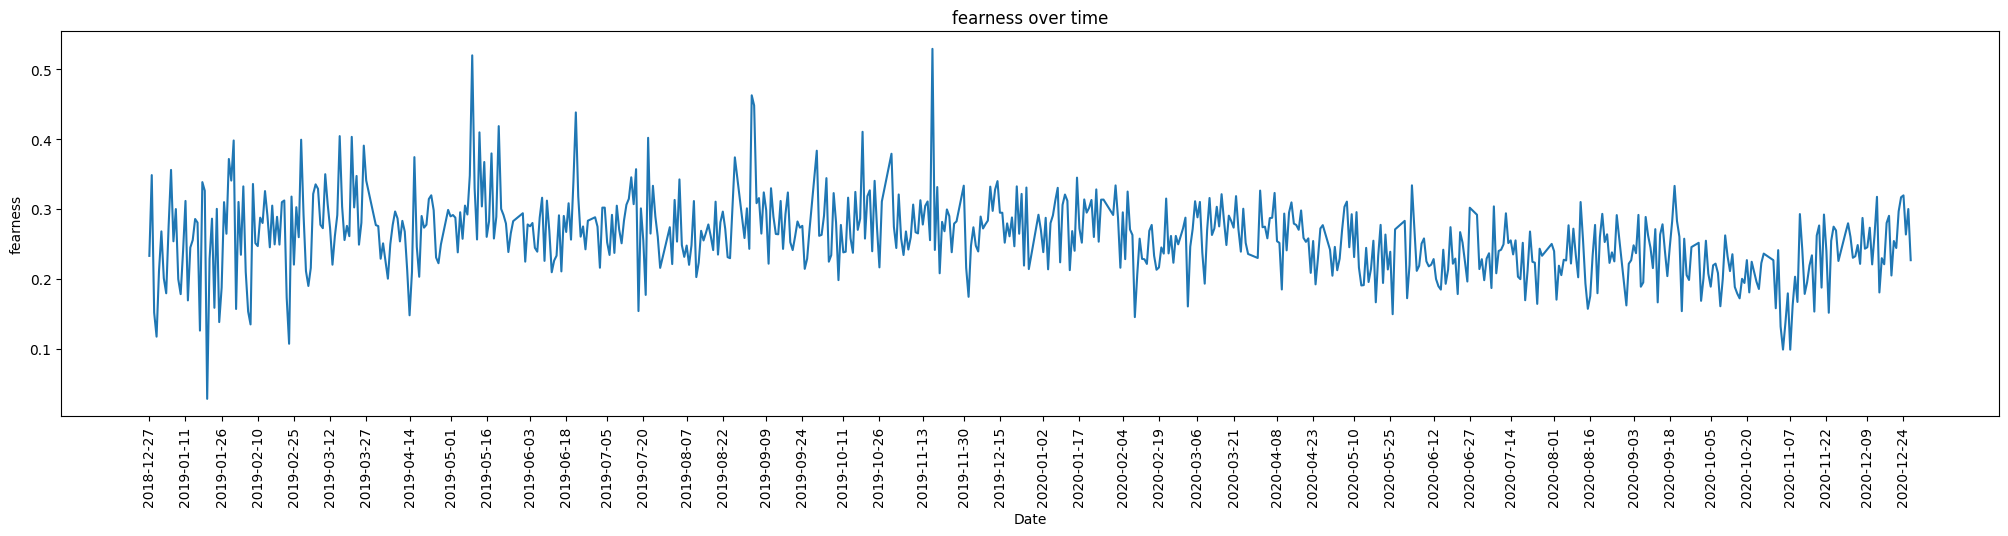

In [98]:
plt.figure(figsize=(25, 5))
plt.plot(daily_fear_df.index, daily_fear_df.values)
plt.xlabel('Date')
plt.ylabel('fearness')
plt.title('fearness over time')
plt.xticks(daily_fear_df.index[::15], rotation=90)
plt.show()

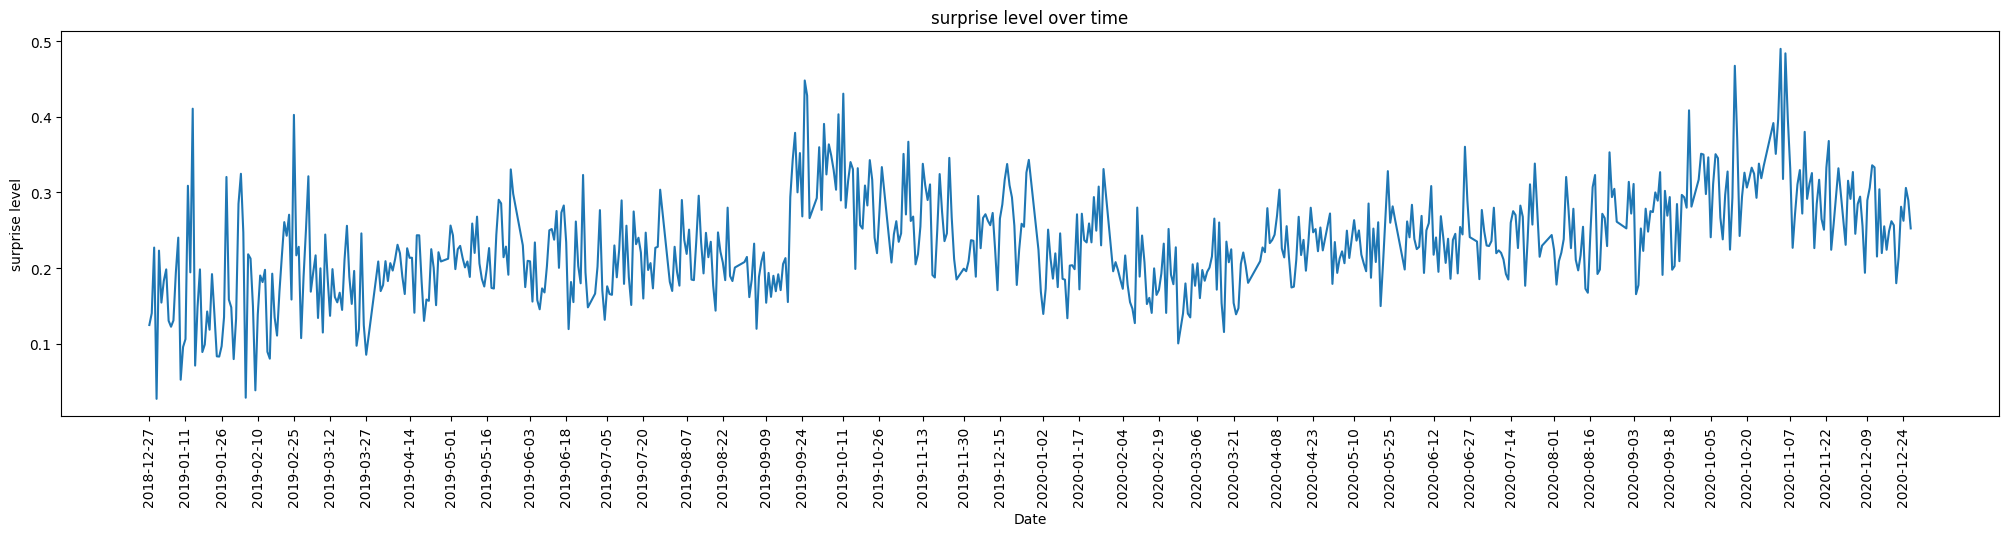

In [100]:
plt.figure(figsize=(25, 5))
plt.plot(daily_surprise_df.index, daily_surprise_df.values)
plt.xlabel('Date')
plt.ylabel('surprise level')
plt.title('surprise level over time')
plt.xticks(daily_surprise_df.index[::15], rotation=90)
plt.show()

Wykresy czasowe dla emocji towarzyszącym tweetom (szczęście, złość, smutek, przerażenie, zaskoczenie)\
wszystkie wykresy wyglądają podobnie, oprócz wykresu dla zaskoczenia. Nagłe wzrosty i wahania można tłumaczyć zaskakującymi zdarzeniami, faktami. Widać wyraźny skok dokładnie 24 września 2019 roku, co pokrywa się ze wszczęciem śledztwa w sprawie impeachmentu Donalda Trumpa. Kolejny wzrost można zauważyć w listopadzie 2020 roku w trakcie wyborów prezydenckich, wtedy były wstępne wyniki przewagi Joe Bidena.

### Podsumowanie

Zdecydowana większość tweetów na temat Joe Bidena w okresie styczeń 2019-grudzień 2020 odnosi się do wyborów prezydenckich, partii i przeciwnika w wyborach. Na wszystkich wykresach można zobaczyć wahania opinii i emocji od stycznia do kwietnia 2019 roku - w kwietniu Joe Biden ogłosił swoją kandydature na Prezdyenta Stanów Zjednoczonych, co mogło powstrzymać rozbieżność w opiniach i emocjach na temat jego startu w wyborach.

### Bibliografia
- https://pl.wikipedia.org/wiki/Joe_Biden
- https://www.nltk.org/book/ch03.html
- https://realpython.com/python-nltk-sentiment-analysis/
- https://pypi.org/project/text2emotion/
- https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-rule-based-vader-and-nltk-72067970fb71
- https://absentdata.com/python-graphs/python-word-frequency/